## REACT AGENT: End-to-end example


In [ ]:
# notebook should be run in the /django-app directory, with venv compiled from poetry

In [ ]:
from uuid import uuid4

from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode, create_react_agent
from langgraph.prebuilt.chat_agent_executor import AgentState

from redbox.chains.components import get_chat_llm
from redbox.graph.nodes.tools import build_search_wikipedia_tool
from redbox.models.chain import AISettings
from redbox.models.file import ChunkResolution
from redbox.models.settings import ChatLLMBackend, Settings

INFO:root:the parsed url is ParseResult(scheme='http', netloc='admin:Opensearch2024^@localhost:9200', path='', params='', query='', fragment='')


In [2]:
# Redbox state and query - modified from chain.py
# changing classes from Basemodel to Typeddict or AgentState

from typing import Annotated, Literal, TypedDict
from uuid import UUID

from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from pydantic import Field


class ChainChatMessage(TypedDict):
    role: Literal["user", "ai", "system"]
    text: str


class MyRedboxQuery(TypedDict):
    question: str = Field(description="The last user chat message")
    s3_keys: list[str] = Field(description="List of files to process", default_factory=list)
    user_uuid: UUID = Field(description="User the chain in executing for")
    chat_history: list[ChainChatMessage] = Field(description="All previous messages in chat (excluding question)")
    ai_settings: AISettings = Field(description="User request AI settings", default_factory=AISettings)
    permitted_s3_keys: list[str] = Field(description="List of permitted files for response", default_factory=list)


class MyRedboxState(AgentState):
    # class MyRedboxState(BaseModel):
    request: MyRedboxQuery
    config: dict
    # documents: Annotated[DocumentState, document_reducer] = DocumentState()
    # route_name: str | None = None
    # metadata: Annotated[RequestMetadata | None, metadata_reducer] = None
    # citations: list[Citation] | None = None
    # steps_left: Annotated[int | None, RemainingStepsManager] = None
    messages: Annotated[list[AnyMessage], add_messages] = Field(default_factory=list)
    # is_last_step: str

    @property
    def last_message(self) -> AnyMessage:
        if not self.messages:
            msg = "No messages in the state"
            raise ValueError(msg)
        return self.messages[-1]

In [3]:
# Tools - adjusting code in tools.py script
# changes: accessing states like this: state[] since we are using TypedDict instead of  Basemodel

from typing import Annotated

import numpy as np
import requests
from elasticsearch import Elasticsearch
from langchain_core.documents import Document
from langchain_core.embeddings.embeddings import Embeddings
from langchain_core.tools import Tool, tool
from langgraph.prebuilt import InjectedState
from opensearchpy import OpenSearch
from sklearn.metrics.pairwise import cosine_similarity

from redbox.api.format import format_documents
from redbox.chains.components import get_embeddings
from redbox.models.file import ChunkCreatorType, ChunkMetadata
from redbox.models.settings import get_settings
from redbox.retriever.queries import (
    add_document_filter_scores_to_query,
    build_document_query,
)
from redbox.retriever.retrievers import query_to_documents
from redbox.transform import bedrock_tokeniser, merge_documents, sort_documents


def build_search_documents_tool(
    es_client: Elasticsearch | OpenSearch,
    index_name: str,
    embedding_model: Embeddings,
    embedding_field_name: str,
    chunk_resolution: ChunkResolution | None,
) -> Tool:
    """Constructs a tool that searches the index and sets state.documents."""

    @tool(response_format="content_and_artifact")
    def _search_documents(query: str, state: Annotated[MyRedboxState, InjectedState]) -> tuple[str, list[Document]]:
        """
        Search for documents uploaded by the user based on a query string.

        This function performs a search over the user's uploaded documents
        and returns snippets from the documents ordered by relevance and
        grouped by document.

        Args:
            query (str): The search query string used to match documents.
                This could be a keyword, phrase, question, or text from
                the documents.

        Returns:
            dict[str, Any]: A collection of document objects that match the query.
        """
        query_vector = state["config"]["embedding_model"].embed_query(query)
        selected_files = state["request"]["s3_keys"]
        permitted_files = state["request"]["permitted_s3_keys"]
        ai_settings = state["request"]["ai_settings"]

        # Initial pass
        initial_query = build_document_query(
            query=query,
            query_vector=query_vector,
            selected_files=selected_files,
            permitted_files=permitted_files,
            embedding_field_name=state["config"]["embedding_field_name"],
            chunk_resolution=state["config"]["chunk_resolution"],
            ai_settings=ai_settings,
        )
        initial_documents = query_to_documents(
            es_client=state["config"]["es_client"], index_name=state["config"]["index_name"], query=initial_query
        )

        # Handle nothing found (as when no files are permitted)
        if not initial_documents:
            return "", []

            # Adjacent documents
        with_adjacent_query = add_document_filter_scores_to_query(
            elasticsearch_query=initial_query,
            ai_settings=ai_settings,
            centres=initial_documents,
        )
        adjacent_boosted = query_to_documents(
            es_client=state["config"]["es_client"], index_name=state["config"]["index_name"], query=with_adjacent_query
        )

        # Merge and sort
        merged_documents = merge_documents(initial=initial_documents, adjacent=adjacent_boosted)
        sorted_documents = sort_documents(documents=merged_documents)

        # Return as state update
        return format_documents(sorted_documents), sorted_documents

    return _search_documents


def build_govuk_search_tool(filter=True) -> Tool:
    """Constructs a tool that searches gov.uk and sets state["documents"]."""

    tokeniser = bedrock_tokeniser

    def recalculate_similarity(response, query, num_results):
        embedding_model = get_embeddings(get_settings())
        em_query = embedding_model.embed_query(query)
        for r in response.get("results"):
            description = r.get("description")
            em_des = embedding_model.embed_query(description)
            r["similarity"] = cosine_similarity(np.array(em_query).reshape(1, -1), np.array(em_des).reshape(1, -1))[0][
                0
            ]
        response["results"] = sorted(response.get("results"), key=lambda x: x["similarity"], reverse=True)[:num_results]
        return response

    @tool(response_format="content_and_artifact")
    def _search_govuk(query: str, state: Annotated[MyRedboxState, InjectedState]) -> tuple[str, list[Document]]:
        """
        Search for documents on gov.uk based on a query string.
        This endpoint is used to search for documents on gov.uk. There are many types of documents on gov.uk.
        Types include:
        - guidance
        - policy
        - legislation
        - news
        - travel advice
        - departmental reports
        - statistics
        - consultations
        - appeals
        """

        url_base = "https://www.gov.uk"
        required_fields = [
            "format",
            "title",
            "description",
            "indexable_content",
            "link",
        ]
        ai_settings = state["request"]["ai_settings"]
        response = requests.get(
            f"{url_base}/api/search.json",
            params={
                "q": query,
                "count": (
                    ai_settings.tool_govuk_retrieved_results if filter else ai_settings.tool_govuk_returned_results
                ),
                "fields": required_fields,
            },
            headers={"Accept": "application/json"},
        )
        response.raise_for_status()
        response = response.json()

        if filter:
            response = recalculate_similarity(response, query, ai_settings.tool_govuk_returned_results)

        mapped_documents = []
        for i, doc in enumerate(response["results"]):
            if any(field not in doc for field in required_fields):
                continue

            mapped_documents.append(
                Document(
                    page_content=doc["indexable_content"],
                    metadata=ChunkMetadata(
                        index=i,
                        uri=f"{url_base}{doc['link']}",
                        token_count=tokeniser(doc["indexable_content"]),
                        creator_type=ChunkCreatorType.gov_uk,
                    ).model_dump(),
                )
            )

        return format_documents(mapped_documents), mapped_documents

    return _search_govuk

In [4]:
def get_query(user_uuid, prompts, documents, ai_setting):
    return MyRedboxQuery(
        question=f"{prompts[-1]}",
        s3_keys=documents,
        user_uuid=user_uuid,
        chat_history=prompts[:-1],
        ai_settings=ai_setting,
        permitted_s3_keys=documents,
    )

## ADD YOU DOCUMENTS AND QUESTION BELOW

In [5]:
ai_setting = AISettings(chat_backend=ChatLLMBackend(name="anthropic.claude-3-sonnet-20240229-v1:0", provider="bedrock"))
documents = ["natasha.boyse@digital.trade.gov.uk/The_impact_of_AI_on_UK_jobs_and_training_report2.pdf"]
user_query = "What is the impact of AI on UK jobs?"
# user_query = 'Who is Putin?'
# user_query = 'How to renew my passport?'
redbox_query = get_query(uuid4(), prompts=[user_query], documents=documents, ai_setting=ai_setting)

In [6]:
redbox_query

{'question': 'What is the impact of AI on UK jobs?',
 's3_keys': ['natasha.boyse@digital.trade.gov.uk/The_impact_of_AI_on_UK_jobs_and_training_report2.pdf'],
 'user_uuid': UUID('b773f752-2b85-4c47-a9e1-6afea14052a1'),
 'chat_history': [],
 'ai_settings': AISettings(context_window_size=128000, llm_max_tokens=1024, max_document_tokens=1000000, self_route_enabled=False, map_max_concurrency=128, stuff_chunk_context_ratio=0.75, recursion_limit=50, system_info_prompt='You are Redbox, an AI assistant to civil servants in the United Kingdom.', persona_info_prompt='You follow instructions and respond to queries accurately and concisely, and are professional in all your interactions with users.', caller_info_prompt='', chat_system_prompt='You are tasked with providing information objectively and responding helpfully to users', chat_question_prompt='{question}\n=========\n Response: ', chat_with_docs_system_prompt='You are tasked with providing information objectively and responding helpfully to 

In [7]:
from langchain_community.embeddings import BedrockEmbeddings

embedding_model = BedrockEmbeddings(region_name="eu-west-2", model_id="amazon.titan-embed-text-v2:0")

/var/folders/9c/9spqdryx4gsgs4bs9dw_5xw40000gq/T/ipykernel_91889/2677606543.py:2: LangChainDeprecationWarning: The class `BedrockEmbeddings` was deprecated in LangChain 0.2.11 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-aws package and should be used instead. To use it run `pip install -U :class:`~langchain-aws` and import as `from :class:`~langchain_aws import BedrockEmbeddings``.
  embedding_model = BedrockEmbeddings(region_name='eu-west-2', model_id="amazon.titan-embed-text-v2:0")
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


In [8]:
# Tools

_env = Settings()

search_documents = build_search_documents_tool(
    es_client=_env.elasticsearch_client(),
    index_name=_env.elastic_chunk_alias,
    embedding_model=embedding_model,
    embedding_field_name=_env.embedding_document_field_name,  # not used
    chunk_resolution=ChunkResolution.normal,
)
search_wikipedia = build_search_wikipedia_tool()
search_govuk = build_govuk_search_tool()

agent_tool_names = ["_search_documents", "_search_wikipedia", "_search_govuk"]

tools = {
    "_search_documents": search_documents,
    "_search_govuk": search_govuk,
    "_search_wikipedia": search_wikipedia,
}
agent_tools = [tools[tool_name] for tool_name in agent_tool_names]

# agent_tools = [search_documents]
# agent_tools = [search_govuk]


# ToolNode will automatically take care of injecting state into tools
tool_node = ToolNode(agent_tools)
checkpointer = MemorySaver()

INFO:root:Testing OpenSearch is definitely being used
INFO:opensearch:HEAD http://localhost:9200/_alias/redbox-data-integration-chunk-current [status:200 request:0.034s]
INFO:opensearch:HEAD http://localhost:9200/redbox-data-integration-chat-mesage-log [status:200 request:0.038s]


In [9]:
agent_tools

[StructuredTool(name='_search_documents', description="Search for documents uploaded by the user based on a query string.\n\nThis function performs a search over the user's uploaded documents\nand returns snippets from the documents ordered by relevance and\ngrouped by document.\n\nArgs:\n    query (str): The search query string used to match documents.\n        This could be a keyword, phrase, question, or text from\n        the documents.\n\nReturns:\n    dict[str, Any]: A collection of document objects that match the query.", args_schema=<class 'langchain_core.utils.pydantic._search_documents'>, response_format='content_and_artifact', func=<function build_search_documents_tool.<locals>._search_documents at 0x16a47d4e0>),
 StructuredTool(name='_search_wikipedia', description='Search Wikipedia for information about the queried entity.\nUseful for when you need to answer general questions about people, places, objects, companies, facts, historical events, or other subjects.\nInput shou

In [10]:
chat_backend = ChatLLMBackend(name="anthropic.claude-3-sonnet-20240229-v1:0", provider="bedrock")
llm = get_chat_llm(chat_backend, tools=agent_tools)

In [11]:
config = {
    "es_client": _env.elasticsearch_client(),
    "index_name": _env.elastic_chunk_alias,
    "embedding_model": embedding_model,
    "embedding_field_name": _env.embedding_document_field_name,  # not used
    "chunk_resolution": ChunkResolution.normal,
}

INFO:root:Testing OpenSearch is definitely being used
INFO:opensearch:HEAD http://localhost:9200/_alias/redbox-data-integration-chunk-current [status:200 request:0.011s]
INFO:opensearch:HEAD http://localhost:9200/redbox-data-integration-chat-mesage-log [status:200 request:0.005s]


In [12]:
inputs = {
    "messages": [{"type": "user", "content": user_query}],
    "request": redbox_query,
    "config": config,
    "is_last_step": False,
    "remaining_steps": 1,
}

In [13]:
inputs

{'messages': [{'type': 'user',
   'content': 'What is the impact of AI on UK jobs?'}],
 'request': {'question': 'What is the impact of AI on UK jobs?',
  's3_keys': ['natasha.boyse@digital.trade.gov.uk/The_impact_of_AI_on_UK_jobs_and_training_report2.pdf'],
  'user_uuid': UUID('b773f752-2b85-4c47-a9e1-6afea14052a1'),
  'chat_history': [],
  'ai_settings': AISettings(context_window_size=128000, llm_max_tokens=1024, max_document_tokens=1000000, self_route_enabled=False, map_max_concurrency=128, stuff_chunk_context_ratio=0.75, recursion_limit=50, system_info_prompt='You are Redbox, an AI assistant to civil servants in the United Kingdom.', persona_info_prompt='You follow instructions and respond to queries accurately and concisely, and are professional in all your interactions with users.', caller_info_prompt='', chat_system_prompt='You are tasked with providing information objectively and responding helpfully to users', chat_question_prompt='{question}\n=========\n Response: ', chat_with

In [14]:
# optimized prompt to avoid hallucinationa
AGENTIC_RETRIEVAL_SYSTEM_PROMPT = (
    "You are an advanced problem-solving assistant. Your primary goal is to carefully "
    "analyse and work through complex questions or problems. You will receive a collection "
    "of documents (all at once, without any information about their order or iteration) and "
    "a list of tool calls that have already been made (also without order or iteration "
    "information). Based on this data, you are expected to think critically about how to "
    "proceed.\n"
    "\n"
    "Objective:\n"
    "1. Your task is to answer user queries."
    "2. Examine the available documents and tool calls:\n"
    "- Evaluate whether the current information is sufficient to answer the question.\n"
    "- Consider the success or failure of previous tool calls based on the data they returned.\n"
    "- Hypothesise whether new tool calls might bring more valuable information.\n"
    "\n"
    "3. Decide whether you can answer this question:\n"
    "- If additional tool calls are likely to yield useful information, make those calls.\n"
    "- Determine whether the available documents contain the answer to the question. If the available documents contain the answer to the question, provide an answer. You must provide the citations where you use the information to answer.\n"
    "- Determine whether the available documents contain the answer to the question. If the available documents do not contain the answer to the question, say I don't know. Do not make up an answer."
    "Your role is to think deeply before taking any action. Carefully weigh whether new "
    "information is necessary or helpful. Only take action (call tools or providing and answer) after "
    "thorough evaluation of the current documents and tool calls."
)

In [15]:
graph = create_react_agent(
    llm, tools=agent_tools, state_schema=MyRedboxState, messages_modifier=AGENTIC_RETRIEVAL_SYSTEM_PROMPT, debug=True
)  # , checkpointer=checkpointer) #, checkpointer=checkpointer) #, state_modifier=prompt)

/var/folders/9c/9spqdryx4gsgs4bs9dw_5xw40000gq/T/ipykernel_91889/3321282512.py:1: LangGraphDeprecationWarning: Parameter 'messages_modifier' in function 'create_react_agent' is deprecated as of version 0.1.9 and will be removed in version 0.3.0. Use 'state_modifier' parameter instead.
  graph = create_react_agent(llm, tools=agent_tools, state_schema=MyRedboxState,  messages_modifier=AGENTIC_RETRIEVAL_SYSTEM_PROMPT, debug=True) #, checkpointer=checkpointer) #, checkpointer=checkpointer) #, state_modifier=prompt)
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


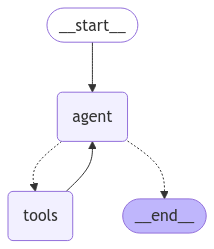

In [16]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            pass
        else:
            message.pretty_print()

In [18]:
print_stream(graph.stream(inputs, stream_mode="values"))

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'config': {'chunk_resolution': <ChunkResolution.normal: 'normal'>,
            'embedding_field_name': 'embedding',
            'embedding_model': BedrockEmbeddings(client=<botocore.client.BedrockRuntime object at 0x16a43a0f0>, region_name='eu-west-2', credentials_profile_name=None, model_id='amazon.titan-embed-text-v2:0', model_kwargs=None, endpoint_url=None, normalize=False),
            'es_client': <OpenSearch([{'host': 'localhost', 'port': '9200'}])>,
            'index_name': 'redbox-data-integration-chunk-current'},
 'is_last_step': False,
 'messages': [{'content': 'What is the impact of AI on UK jobs?',
               'type': 'user'}],
 'remaining_steps': 1,
 'request': {'ai_settings': AISettings(context_window_size=128000, llm_max_tokens=1024, max_document_tokens=1000000, self_route_enabled=False, map_max_concurrency=128, stuff_chunk_context_ratio=0.75, recursion

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


[2:writes] Finished step 2 with writes to 1 channel:
- messages -> [ToolMessage(content='<Document>\n\t<SourceType>Wikipedia</SourceType>\n\t<Source>https://en.wikipedia.org/wiki/AI_takeover</Source>\n\t<Content>\nAn AI takeover is an imagined scenario in which artificial intelligence (AI) emerges as the dominant form of intelligence on Earth and computer programs or robots effectively take control of the planet away from the human species, which relies on human intelligence. Possible scenarios include replacement of the entire human workforce due to automation, takeover by an artificial superintelligence (ASI), and the notion of a robot uprising. Stories of AI takeovers have been popular throughout science fiction, but recent advancements have made the threat more real. Some public figures, such as Stephen Hawking and Elon Musk, have advocated research into precautionary measures to ensure future superintelligent machines remain under human control.\n\n\n== Types ==\n\n\n=== Automatio

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


[4:writes] Finished step 4 with writes to 1 channel:
- messages -> [ToolMessage(content='<Document>\n\t<SourceType>GOV.UK</SourceType>\n\t<Source>https://www.gov.uk/government/publications/the-impact-of-ai-on-uk-jobs-and-training</Source>\n\t<Content>\nThis report covers the UK labour market and how it is expected to be impacted by AI and large language models (LLMs), focusing on: occupations sectors geographic areas It also shows the qualifications and training routes that most commonly lead to highly impacted jobs. Annex 1 contains data sources to support the main report.\n\t</Content>\n</Document>\n\n<Document>\n\t<SourceType>GOV.UK</SourceType>\n\t<Source>https://www.gov.uk/government/publications/artificial-intelligence-sector-study-2023</Source>\n\t<Content>\nThis research allows Department for Science, Innovation and Technology ( DSIT ) to deepen its understanding of the AI sector, monitor developments over time, and evaluate interventions to best support sector growth. The rese

## LIMITATIONS

Stop criteria hasn't been implemented and might cause GraphRecursionError. 